# Finding an Optimal Restaurant Location and Cuisine Preference for Visitors in Birmingham, UK - Coursera Capstone Project

In [1]:
#importing all required libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

In [2]:
#required information to call Foursquare API

CLIENT_ID = 'XY33XDFEU023CZ4LT3300MUVID3TBIZML0RVQ521ZWLLI5XK' # your Foursquare ID
CLIENT_SECRET = '4YDKTTCQKSHUKBTFBOL15JK3NDCC4STBGWGQFJVYJ4VBY1SP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
#setting the location to be searched, search word, and limits on results

#Birmingham location
Birm_lat = 52.4775
Birm_lon = -1.929
search_query = 'Hotel'
radius = 2000
limit_hotels = 200

In [4]:
#url for calling the API

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Birm_lat, Birm_lon, VERSION, search_query, radius, limit_hotels)
url

'https://api.foursquare.com/v2/venues/search?client_id=XY33XDFEU023CZ4LT3300MUVID3TBIZML0RVQ521ZWLLI5XK&client_secret=4YDKTTCQKSHUKBTFBOL15JK3NDCC4STBGWGQFJVYJ4VBY1SP&ll=52.4775,-1.929&v=20180605&query=Hotel&radius=2000&limit=200'

In [5]:
#saving the results

results = requests.get(url).json()

In [6]:
# assign relevant part of JSON to venues
hotels = results['response']['venues']

# tranform venues into a dataframe
hotels_df = json_normalize(hotels)
hotels_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.crossStreet,location.neighborhood
0,4b058828f964a52046b522e3,Best Western The Plough & Harrow Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1613618137,False,135 Hagley Rd.,52.472189,-1.927418,"[{'label': 'display', 'lat': 52.472189, 'lng':...",600,B16 8LS,GB,Birmingham,West Midlands,United Kingdom,"[135 Hagley Rd., Birmingham, West Midlands, B1...",NaN,NaN,NaN
1,4bc779e093bdeee1926c37ae,Hallmark Strathallan Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1613618137,False,225 Hagley Rd,52.472133,-1.937858,"[{'label': 'display', 'lat': 52.47213326085399...",847,B16 9RY,GB,Birmingham,West Midlands,United Kingdom,"[225 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,NaN
2,54fa1e91498eb43825671e7e,Cobdel Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1613618137,False,166 Hagley Rd,52.471865,-1.939312,"[{'label': 'display', 'lat': 52.47186483035182...",939,B16 9NZ,GB,Birmingham,West Midlands,United Kingdom,"[166 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,NaN
3,570673e7498e909686bcccce,AC Hotel by Marriott Birmingham,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1613618137,False,"160 Wharfside Street, The Mailbox",52.475198,-1.906108,"[{'label': 'display', 'lat': 52.475198, 'lng':...",1573,B1 1RL,GB,Birmingham,West Midlands,United Kingdom,"[160 Wharfside Street, The Mailbox, Birmingham...",422703144,NaN,NaN
4,4eee6a37003937534527c5ba,Hotel Indigo Birmingham,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1613618137,False,"The Cube, Wharfside St",52.474923,-1.906575,"[{'label': 'display', 'lat': 52.4749228, 'lng'...",1547,B1 1RS,GB,Birmingham,West Midlands,United Kingdom,"[The Cube, Wharfside St (at Commercial St), Bi...",NaN,at Commercial St,NaN


In [7]:
# keep only columns that include venue name, and location information
filtered_columns = ['name', 'categories'] + [col for col in hotels_df.columns if col.startswith('location.')] + ['id']
hotels_df_filtered = hotels_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered['categories'] = hotels_df_filtered.apply(get_category_type, axis=1)

# keeping only last term in column name 
hotels_df_filtered.columns = [column.split('.')[-1] for column in hotels_df_filtered.columns]

hotels_df_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Best Western The Plough & Harrow Hotel,Hotel,135 Hagley Rd.,52.472189,-1.927418,"[{'label': 'display', 'lat': 52.472189, 'lng':...",600,B16 8LS,GB,Birmingham,West Midlands,United Kingdom,"[135 Hagley Rd., Birmingham, West Midlands, B1...",NaN,NaN,4b058828f964a52046b522e3
1,Hallmark Strathallan Hotel,Hotel,225 Hagley Rd,52.472133,-1.937858,"[{'label': 'display', 'lat': 52.47213326085399...",847,B16 9RY,GB,Birmingham,West Midlands,United Kingdom,"[225 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4bc779e093bdeee1926c37ae
2,Cobdel Hotel,Hotel,166 Hagley Rd,52.471865,-1.939312,"[{'label': 'display', 'lat': 52.47186483035182...",939,B16 9NZ,GB,Birmingham,West Midlands,United Kingdom,"[166 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,54fa1e91498eb43825671e7e
3,AC Hotel by Marriott Birmingham,Hotel,"160 Wharfside Street, The Mailbox",52.475198,-1.906108,"[{'label': 'display', 'lat': 52.475198, 'lng':...",1573,B1 1RL,GB,Birmingham,West Midlands,United Kingdom,"[160 Wharfside Street, The Mailbox, Birmingham...",NaN,NaN,570673e7498e909686bcccce
4,Hotel Indigo Birmingham,Hotel,"The Cube, Wharfside St",52.474923,-1.906575,"[{'label': 'display', 'lat': 52.4749228, 'lng'...",1547,B1 1RS,GB,Birmingham,West Midlands,United Kingdom,"[The Cube, Wharfside St (at Commercial St), Bi...",at Commercial St,NaN,4eee6a37003937534527c5ba
5,Copthorne Hotel Birmingham,Hotel,"Paradise Circus, Paradise Place",52.480332,-1.906459,"[{'label': 'display', 'lat': 52.48033191682519...",1560,B3 3HJ,GB,Warwickshire,Warwickshire,United Kingdom,"[Paradise Circus, Paradise Place (Centenary Sq...",Centenary Square,NaN,51818544c84c71399407eca0
6,Norfolk Hotel,Hotel,257 Hagley Rd,52.471853,-1.944884,"[{'label': 'display', 'lat': 52.47185277388954...",1247,B16 9NA,GB,Birmingham,West Midlands,United Kingdom,"[257 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4b058829f964a5205fb522e3
7,Ibis Styles Hotel,Hotel,65 Lionel Street,52.481824,-1.906615,"[{'label': 'display', 'lat': 52.481824, 'lng':...",1592,B3 1JE,GB,Birmingham,West Midlands,United Kingdom,"[65 Lionel Street, Birmingham, West Midlands, ...",NaN,NaN,5231758e11d299e571a4b4a0
8,BLOC Hotel Birmingham,Hotel,77 Caroline St,52.486143,-1.907939,"[{'label': 'display', 'lat': 52.48614336340986...",1721,B3 1UG,GB,Birmingham,West Midlands,United Kingdom,"[77 Caroline St, Birmingham, West Midlands, B3...",NaN,Jewellery Quarter,4d78babc9e57a0932b13c82b
9,Hotel du Vin & Bistro,Hotel,25 Church St,52.482399,-1.900461,"[{'label': 'display', 'lat': 52.48239866190785...",2010,B3 2NR,GB,Birmingham,West Midlands,United Kingdom,"[25 Church St, Birmingham, West Midlands, B3 2...",NaN,City Centre,4badf914f964a520fd763be3


In [8]:
#keeping only venues with the category "Hotel"

hotels_df_filtered = hotels_df_filtered[hotels_df_filtered.categories == 'Hotel']
hotels_df_filtered.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Best Western The Plough & Harrow Hotel,Hotel,135 Hagley Rd.,52.472189,-1.927418,"[{'label': 'display', 'lat': 52.472189, 'lng':...",600,B16 8LS,GB,Birmingham,West Midlands,United Kingdom,"[135 Hagley Rd., Birmingham, West Midlands, B1...",NaN,NaN,4b058828f964a52046b522e3
1,Hallmark Strathallan Hotel,Hotel,225 Hagley Rd,52.472133,-1.937858,"[{'label': 'display', 'lat': 52.47213326085399...",847,B16 9RY,GB,Birmingham,West Midlands,United Kingdom,"[225 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4bc779e093bdeee1926c37ae
2,Cobdel Hotel,Hotel,166 Hagley Rd,52.471865,-1.939312,"[{'label': 'display', 'lat': 52.47186483035182...",939,B16 9NZ,GB,Birmingham,West Midlands,United Kingdom,"[166 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,54fa1e91498eb43825671e7e
3,AC Hotel by Marriott Birmingham,Hotel,"160 Wharfside Street, The Mailbox",52.475198,-1.906108,"[{'label': 'display', 'lat': 52.475198, 'lng':...",1573,B1 1RL,GB,Birmingham,West Midlands,United Kingdom,"[160 Wharfside Street, The Mailbox, Birmingham...",NaN,NaN,570673e7498e909686bcccce
4,Hotel Indigo Birmingham,Hotel,"The Cube, Wharfside St",52.474923,-1.906575,"[{'label': 'display', 'lat': 52.4749228, 'lng'...",1547,B1 1RS,GB,Birmingham,West Midlands,United Kingdom,"[The Cube, Wharfside St (at Commercial St), Bi...",at Commercial St,NaN,4eee6a37003937534527c5ba
5,Copthorne Hotel Birmingham,Hotel,"Paradise Circus, Paradise Place",52.480332,-1.906459,"[{'label': 'display', 'lat': 52.48033191682519...",1560,B3 3HJ,GB,Warwickshire,Warwickshire,United Kingdom,"[Paradise Circus, Paradise Place (Centenary Sq...",Centenary Square,NaN,51818544c84c71399407eca0
6,Norfolk Hotel,Hotel,257 Hagley Rd,52.471853,-1.944884,"[{'label': 'display', 'lat': 52.47185277388954...",1247,B16 9NA,GB,Birmingham,West Midlands,United Kingdom,"[257 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4b058829f964a5205fb522e3
7,Ibis Styles Hotel,Hotel,65 Lionel Street,52.481824,-1.906615,"[{'label': 'display', 'lat': 52.481824, 'lng':...",1592,B3 1JE,GB,Birmingham,West Midlands,United Kingdom,"[65 Lionel Street, Birmingham, West Midlands, ...",NaN,NaN,5231758e11d299e571a4b4a0
8,BLOC Hotel Birmingham,Hotel,77 Caroline St,52.486143,-1.907939,"[{'label': 'display', 'lat': 52.48614336340986...",1721,B3 1UG,GB,Birmingham,West Midlands,United Kingdom,"[77 Caroline St, Birmingham, West Midlands, B3...",NaN,Jewellery Quarter,4d78babc9e57a0932b13c82b
9,Hotel du Vin & Bistro,Hotel,25 Church St,52.482399,-1.900461,"[{'label': 'display', 'lat': 52.48239866190785...",2010,B3 2NR,GB,Birmingham,West Midlands,United Kingdom,"[25 Church St, Birmingham, West Midlands, B3 2...",NaN,City Centre,4badf914f964a520fd763be3


In [9]:
#resetting index

hotels_df_filtered.reset_index(drop=True, inplace=True)
hotels_df_filtered.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Best Western The Plough & Harrow Hotel,Hotel,135 Hagley Rd.,52.472189,-1.927418,"[{'label': 'display', 'lat': 52.472189, 'lng':...",600,B16 8LS,GB,Birmingham,West Midlands,United Kingdom,"[135 Hagley Rd., Birmingham, West Midlands, B1...",NaN,NaN,4b058828f964a52046b522e3
1,Hallmark Strathallan Hotel,Hotel,225 Hagley Rd,52.472133,-1.937858,"[{'label': 'display', 'lat': 52.47213326085399...",847,B16 9RY,GB,Birmingham,West Midlands,United Kingdom,"[225 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4bc779e093bdeee1926c37ae
2,Cobdel Hotel,Hotel,166 Hagley Rd,52.471865,-1.939312,"[{'label': 'display', 'lat': 52.47186483035182...",939,B16 9NZ,GB,Birmingham,West Midlands,United Kingdom,"[166 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,54fa1e91498eb43825671e7e
3,AC Hotel by Marriott Birmingham,Hotel,"160 Wharfside Street, The Mailbox",52.475198,-1.906108,"[{'label': 'display', 'lat': 52.475198, 'lng':...",1573,B1 1RL,GB,Birmingham,West Midlands,United Kingdom,"[160 Wharfside Street, The Mailbox, Birmingham...",NaN,NaN,570673e7498e909686bcccce
4,Hotel Indigo Birmingham,Hotel,"The Cube, Wharfside St",52.474923,-1.906575,"[{'label': 'display', 'lat': 52.4749228, 'lng'...",1547,B1 1RS,GB,Birmingham,West Midlands,United Kingdom,"[The Cube, Wharfside St (at Commercial St), Bi...",at Commercial St,NaN,4eee6a37003937534527c5ba
5,Copthorne Hotel Birmingham,Hotel,"Paradise Circus, Paradise Place",52.480332,-1.906459,"[{'label': 'display', 'lat': 52.48033191682519...",1560,B3 3HJ,GB,Warwickshire,Warwickshire,United Kingdom,"[Paradise Circus, Paradise Place (Centenary Sq...",Centenary Square,NaN,51818544c84c71399407eca0
6,Norfolk Hotel,Hotel,257 Hagley Rd,52.471853,-1.944884,"[{'label': 'display', 'lat': 52.47185277388954...",1247,B16 9NA,GB,Birmingham,West Midlands,United Kingdom,"[257 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4b058829f964a5205fb522e3
7,Ibis Styles Hotel,Hotel,65 Lionel Street,52.481824,-1.906615,"[{'label': 'display', 'lat': 52.481824, 'lng':...",1592,B3 1JE,GB,Birmingham,West Midlands,United Kingdom,"[65 Lionel Street, Birmingham, West Midlands, ...",NaN,NaN,5231758e11d299e571a4b4a0
8,BLOC Hotel Birmingham,Hotel,77 Caroline St,52.486143,-1.907939,"[{'label': 'display', 'lat': 52.48614336340986...",1721,B3 1UG,GB,Birmingham,West Midlands,United Kingdom,"[77 Caroline St, Birmingham, West Midlands, B3...",NaN,Jewellery Quarter,4d78babc9e57a0932b13c82b
9,Hotel du Vin & Bistro,Hotel,25 Church St,52.482399,-1.900461,"[{'label': 'display', 'lat': 52.48239866190785...",2010,B3 2NR,GB,Birmingham,West Midlands,United Kingdom,"[25 Church St, Birmingham, West Midlands, B3 2...",NaN,City Centre,4badf914f964a520fd763be3


In [10]:
#creating a map to view the resulting hotels and their locations
hotels_map = folium.Map(location=[Birm_lat, Birm_lon], zoom_start=15) # generate map centred around Birmingham

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered.lat, hotels_df_filtered.lng, hotels_df_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

In [11]:
#Number of hotels in Birmingham city center
hotels_df_filtered.shape

(39, 16)

In [12]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n = list(range(1,len(hotels_df_filtered)+1))
hotels_df_filtered['id_n'] = id_n
hotels_df_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id,id_n
0,Best Western The Plough & Harrow Hotel,Hotel,135 Hagley Rd.,52.472189,-1.927418,"[{'label': 'display', 'lat': 52.472189, 'lng':...",600,B16 8LS,GB,Birmingham,West Midlands,United Kingdom,"[135 Hagley Rd., Birmingham, West Midlands, B1...",NaN,NaN,4b058828f964a52046b522e3,1
1,Hallmark Strathallan Hotel,Hotel,225 Hagley Rd,52.472133,-1.937858,"[{'label': 'display', 'lat': 52.47213326085399...",847,B16 9RY,GB,Birmingham,West Midlands,United Kingdom,"[225 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4bc779e093bdeee1926c37ae,2
2,Cobdel Hotel,Hotel,166 Hagley Rd,52.471865,-1.939312,"[{'label': 'display', 'lat': 52.47186483035182...",939,B16 9NZ,GB,Birmingham,West Midlands,United Kingdom,"[166 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,54fa1e91498eb43825671e7e,3
3,AC Hotel by Marriott Birmingham,Hotel,"160 Wharfside Street, The Mailbox",52.475198,-1.906108,"[{'label': 'display', 'lat': 52.475198, 'lng':...",1573,B1 1RL,GB,Birmingham,West Midlands,United Kingdom,"[160 Wharfside Street, The Mailbox, Birmingham...",NaN,NaN,570673e7498e909686bcccce,4
4,Hotel Indigo Birmingham,Hotel,"The Cube, Wharfside St",52.474923,-1.906575,"[{'label': 'display', 'lat': 52.4749228, 'lng'...",1547,B1 1RS,GB,Birmingham,West Midlands,United Kingdom,"[The Cube, Wharfside St (at Commercial St), Bi...",at Commercial St,NaN,4eee6a37003937534527c5ba,5


In [13]:
# The dataset that will be used in K-Means clustering
X=hotels_df_filtered.loc[:,['id_n','lat','lng']]
X.head(10)

,id_n,lat,lng
0,1,52.472189,-1.927418
1,2,52.472133,-1.937858
2,3,52.471865,-1.939312
3,4,52.475198,-1.906108
4,5,52.474923,-1.906575
5,6,52.480332,-1.906459
6,7,52.471853,-1.944884
7,8,52.481824,-1.906615
8,9,52.486143,-1.907939
9,10,52.482399,-1.900461


In [14]:
#clustering the hotels based on their locations 
kmeans = KMeans(n_clusters = 3, init ='k-means++') # hotels will be clustered in 3 groups
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
centers = kmeans.cluster_centers_
print(centers) #to show coordinates of the center for each cluster 
X.head(10)

[[52.47679116 -1.9016361 ]
 [52.47246211 -1.94691708]
 [52.47157626 -1.92183163]]


,id_n,lat,lng,cluster_label
0,1,52.472189,-1.927418,2
1,2,52.472133,-1.937858,1
2,3,52.471865,-1.939312,1
3,4,52.475198,-1.906108,0
4,5,52.474923,-1.906575,0
5,6,52.480332,-1.906459,0
6,7,52.471853,-1.944884,1
7,8,52.481824,-1.906615,0
8,9,52.486143,-1.907939,0
9,10,52.482399,-1.900461,0


In [15]:
#adding the cluster label to each venue in the hotels data frame
X = X[['id_n','cluster_label']]
clustered_hotels = hotels_df_filtered.merge(X, left_on='id_n', right_on='id_n')
clustered_hotels.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id,id_n,cluster_label
0,Best Western The Plough & Harrow Hotel,Hotel,135 Hagley Rd.,52.472189,-1.927418,"[{'label': 'display', 'lat': 52.472189, 'lng':...",600,B16 8LS,GB,Birmingham,West Midlands,United Kingdom,"[135 Hagley Rd., Birmingham, West Midlands, B1...",NaN,NaN,4b058828f964a52046b522e3,1,2
1,Hallmark Strathallan Hotel,Hotel,225 Hagley Rd,52.472133,-1.937858,"[{'label': 'display', 'lat': 52.47213326085399...",847,B16 9RY,GB,Birmingham,West Midlands,United Kingdom,"[225 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,4bc779e093bdeee1926c37ae,2,1
2,Cobdel Hotel,Hotel,166 Hagley Rd,52.471865,-1.939312,"[{'label': 'display', 'lat': 52.47186483035182...",939,B16 9NZ,GB,Birmingham,West Midlands,United Kingdom,"[166 Hagley Rd, Birmingham, West Midlands, B16...",NaN,NaN,54fa1e91498eb43825671e7e,3,1
3,AC Hotel by Marriott Birmingham,Hotel,"160 Wharfside Street, The Mailbox",52.475198,-1.906108,"[{'label': 'display', 'lat': 52.475198, 'lng':...",1573,B1 1RL,GB,Birmingham,West Midlands,United Kingdom,"[160 Wharfside Street, The Mailbox, Birmingham...",NaN,NaN,570673e7498e909686bcccce,4,0
4,Hotel Indigo Birmingham,Hotel,"The Cube, Wharfside St",52.474923,-1.906575,"[{'label': 'display', 'lat': 52.4749228, 'lng'...",1547,B1 1RS,GB,Birmingham,West Midlands,United Kingdom,"[The Cube, Wharfside St (at Commercial St), Bi...",at Commercial St,NaN,4eee6a37003937534527c5ba,5,0


In [16]:
#map showing each hotel with different color based on the cluster
map_clusters = folium.Map(location=[Birm_lat, Birm_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(clustered_hotels['lat'], clustered_hotels['lng'], clustered_hotels['name'], clustered_hotels['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters #show map

In [17]:
#putting the center of each cluster in a dataframe for later analysis
centers_df = pd.DataFrame(centers, columns =['c_lat', 'c_lon'])
cluster_label = list(range(0,3))
centers_df['cluster_label'] = cluster_label
centers_df

,c_lat,c_lon,cluster_label
0,52.476791,-1.901636,0
1,52.472462,-1.946917,1
2,52.471576,-1.921832,2


In [18]:
#map of centers
map_centers = folium.Map(location=[Birm_lat, Birm_lon], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(centers_df['c_lat'], centers_df['c_lon'], centers_df['cluster_label'], centers_df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers)
       
map_centers #display the map showing 3 markers, one for each cluster

In [19]:
#creating the url to call on foursquare API

limit_restaurants = 500

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Birm_lat, 
    Birm_lon, 
    radius, 
    limit_restaurants)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=XY33XDFEU023CZ4LT3300MUVID3TBIZML0RVQ521ZWLLI5XK&client_secret=4YDKTTCQKSHUKBTFBOL15JK3NDCC4STBGWGQFJVYJ4VBY1SP&v=20180605&ll=52.4775,-1.929&radius=2000&limit=500'

In [20]:
#saving the results
results2 = requests.get(url2).json()

In [21]:
#transferring the data to a pandas dataframe
restaurants = results2['response']['groups'][0]['items']
restaurants_df = json_normalize(restaurants)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df = restaurants_df.loc[:, filtered_columns]

# filter the category for each row
restaurants_df['venue.categories'] = restaurants_df.apply(get_category_type, axis=1)

# clean columns
restaurants_df.columns = [col.split(".")[-1] for col in restaurants_df.columns]

restaurants_df

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Edgbaston Reservoir,Reservoir,52.477976,-1.936298
1,Shiraz,Middle Eastern Restaurant,52.471804,-1.930807
2,Fiesta del Asado,Argentinian Restaurant,52.472037,-1.939013
3,The Highfield,Gastropub,52.468662,-1.922498
4,Brindleyplace,Shopping Plaza,52.477904,-1.913134
5,Simpsons,Restaurant,52.468400,-1.922986
6,The Edgbaston Boutique Hotel & Cocktail Lounge,Hotel,52.468831,-1.923364
7,The Pig & Tail,Pub,52.484563,-1.914378
8,Laghi’s Deli,Deli / Bodega,52.472479,-1.917282
9,The Physician,Pub,52.470407,-1.924173


In [22]:
#number of venues recieved
restaurants_df.shape

(100, 4)

In [23]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_temp = restaurants_df[restaurants_df['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_temp.shape) #number of restaurants
restaurants_df_temp

(25, 4)


,name,categories,lat,lng
0,Shiraz,Middle Eastern Restaurant,52.471804,-1.930807
1,Fiesta del Asado,Argentinian Restaurant,52.472037,-1.939013
2,Simpsons,Restaurant,52.468400,-1.922986
3,Frankie & Benny's,American Restaurant,52.473433,-1.921810
4,Rajdoot Tandoori,Indian Restaurant,52.482635,-1.910547
5,The Blue Piano,Asian Restaurant,52.470897,-1.922317
6,Nom Nom Noodles,Vietnamese Restaurant,52.485428,-1.920903
7,Pushkar,Indian Restaurant,52.476987,-1.911958
8,Côte Brasserie,French Restaurant,52.475447,-1.906496
9,Itihaas,Indian Restaurant,52.483254,-1.906007


In [24]:
#dropping catergories only decribing "Restaurant" without type of cuisine
restaurants_df_cleaned = restaurants_df_temp.drop([2,10,11,16])
restaurants_df_cleaned.head()

#reset index
restaurants_df_cleaned.reset_index(drop=True, inplace=True)
restaurants_df_cleaned.head(5)

,name,categories,lat,lng
0,Shiraz,Middle Eastern Restaurant,52.471804,-1.930807
1,Fiesta del Asado,Argentinian Restaurant,52.472037,-1.939013
2,Frankie & Benny's,American Restaurant,52.473433,-1.921810
3,Rajdoot Tandoori,Indian Restaurant,52.482635,-1.910547
4,The Blue Piano,Asian Restaurant,52.470897,-1.922317


In [25]:
#creating a map of restaurants
restaurants_map = folium.Map(location=[Birm_lat, Birm_lon], zoom_start=15) # generate map centred around Birmingham

# add the hotels as yellow circle markers
for lat, lng, label in zip(restaurants_df_cleaned.lat, restaurants_df_cleaned.lng, restaurants_df_cleaned.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='purple',
        popup=label,
        fill = True,
        fill_color='purple',
        fill_opacity=0.6
    ).add_to(restaurants_map)

# display map
restaurants_map

In [26]:
#preparing the data that will be used in KNN classification
Xhat=restaurants_df_cleaned.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat.shape) #number of restaurants
Xhat.head(5) #show dataframe

(21, 2)


,lat,lng
0,52.471804,-1.930807
1,52.472037,-1.939013
2,52.473433,-1.921810
3,52.482635,-1.910547
4,52.470897,-1.922317


In [27]:
#the centers dataframe to be used for training KNN
centers_df

,c_lat,c_lon,cluster_label
0,52.476791,-1.901636,0
1,52.472462,-1.946917,1
2,52.471576,-1.921832,2


In [28]:
#selecting classification features and target variable
X_train = centers_df[['c_lat', 'c_lon']].values
Y_train = centers_df['cluster_label']

In [29]:
#importing KNN library
from sklearn.neighbors import KNeighborsClassifier

In [30]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [31]:
#classify the restaurants based on the model created
yhat = neigh.predict(Xhat)
yhat[0:5]

array([2, 1, 2, 0, 2])

In [32]:
#putting the results in a dataframe
KNN_results = pd.DataFrame(yhat, columns=['class'])
KNN_results

,class
0,2
1,1
2,2
3,0
4,2
5,2
6,0
7,0
8,0
9,0


In [33]:
#joining the results with the restaurants dataframe
restaurants_classified = pd.concat([restaurants_df_cleaned, KNN_results], axis=1, sort=False)

In [34]:
#view resulting dataframe
restaurants_classified

,name,categories,lat,lng,class
0,Shiraz,Middle Eastern Restaurant,52.471804,-1.930807,2
1,Fiesta del Asado,Argentinian Restaurant,52.472037,-1.939013,1
2,Frankie & Benny's,American Restaurant,52.473433,-1.921810,2
3,Rajdoot Tandoori,Indian Restaurant,52.482635,-1.910547,0
4,The Blue Piano,Asian Restaurant,52.470897,-1.922317,2
5,Nom Nom Noodles,Vietnamese Restaurant,52.485428,-1.920903,2
6,Pushkar,Indian Restaurant,52.476987,-1.911958,0
7,Côte Brasserie,French Restaurant,52.475447,-1.906496,0
8,Itihaas,Indian Restaurant,52.483254,-1.906007,0
9,Dishoom,Indian Restaurant,52.480323,-1.904520,0


In [35]:
#show restaurante in each area in different color
map_rest_class = folium.Map(location=[Birm_lat, Birm_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(restaurants_classified['lat'], restaurants_classified['lng'], restaurants_classified['name'], restaurants_classified['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class)
       
map_rest_class

In [36]:
#count number of restaurants in each area
restaurants_count = restaurants_classified['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count

,class,counts
0,0,13
1,2,5
2,1,3


In [37]:
#counting number of trending restaurants of each unique category
trending_restaurants = restaurants_classified['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants

,categories,counts
0,Indian Restaurant,8
1,Italian Restaurant,2
2,Tapas Restaurant,2
3,American Restaurant,2
4,Asian Restaurant,1
5,French Restaurant,1
6,Vietnamese Restaurant,1
7,Portuguese Restaurant,1
8,Middle Eastern Restaurant,1
9,South American Restaurant,1


In [38]:
#keeping the five most frequent categories
trending_restaurants = trending_restaurants.head()

In [39]:
#show top five categories
trending_restaurants

,categories,counts
0,Indian Restaurant,8
1,Italian Restaurant,2
2,Tapas Restaurant,2
3,American Restaurant,2
4,Asian Restaurant,1


In [40]:
#make "categories" as index for visiualization
trending_restaurants = trending_restaurants.set_index('categories')
trending_restaurants

,counts
categories,
Indian Restaurant,8
Italian Restaurant,2
Tapas Restaurant,2
American Restaurant,2
Asian Restaurant,1


In [41]:
#importing bar charts library
import matplotlib as mpl
import matplotlib.pyplot as plt

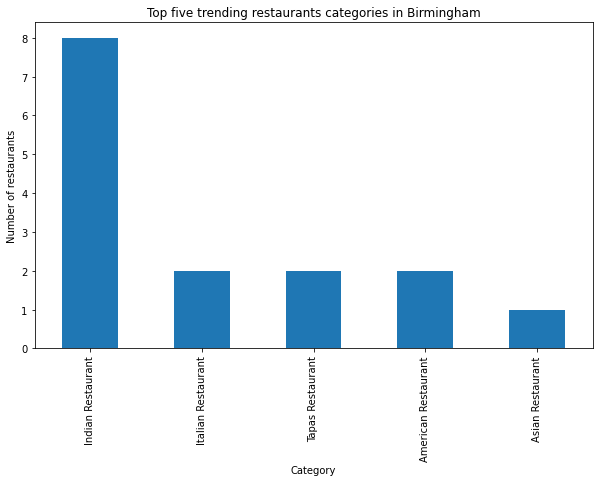

In [47]:
#plotting the top five restaurant categories
trending_restaurants.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in Birmingham') # add title to the plot

plt.show()

In [43]:
#counting hotels in each area to evaluate potential
hotels_count = clustered_hotels['cluster_label'].value_counts().rename_axis('cluster').reset_index(name='counts')
hotels_count

,cluster,counts
0,0,21
1,1,14
2,2,4


In [44]:
#new df with only "Indian Restaurant"
restaurants_df_indian = restaurants_classified[restaurants_classified['categories'].str.contains('Indian Restaurant')].reset_index(drop=True)
print(restaurants_df_indian.shape) #number of restaurants
restaurants_df_indian

(8, 5)


,name,categories,lat,lng,class
0,Rajdoot Tandoori,Indian Restaurant,52.482635,-1.910547,0
1,Pushkar,Indian Restaurant,52.476987,-1.911958,0
2,Itihaas,Indian Restaurant,52.483254,-1.906007,0
3,Dishoom,Indian Restaurant,52.480323,-1.904520,0
4,Lasan,Indian Restaurant,52.485087,-1.907824,0
5,Asha's Contemporary Indian Cuisine,Indian Restaurant,52.481398,-1.901992,0
6,Tamatanga,Indian Restaurant,52.477826,-1.902516,0
7,Akbar's,Indian Restaurant,52.471299,-1.941695,1


In [46]:
#creating a map of indian restaurants
restaurants_map_indian = folium.Map(location=[Birm_lat, Birm_lon], zoom_start=15) # generate map centred around Birmingham

# add the restaurant locations as yellow circle markers
for lat, lng, label in zip(restaurants_df_indian.lat, restaurants_df_indian.lng, restaurants_df_indian.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=15,
        color='purple',
        popup=label,
        fill = True,
        fill_color='purple',
        fill_opacity=0.6
    ).add_to(restaurants_map_indian)

# display map
restaurants_map_indian